# Data Wrangling of the AirBnb Data set

Steps: standardize column names, parse dates, fix booleans, coerce numerics, cap outliers, fill/select NA strategies, and create tidy derived fields.


In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **DATA ACCESS**


In [145]:
df =pd.read_csv('/content/Airbnb_Open_Data (1).csv',low_memory=False)

In [146]:
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,19/10/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,21/05/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,05/07/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,19/11/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [147]:
df.shape

(102599, 26)

# **DATA CLEANING**

In [148]:
# 1) Standardize column names: snake_case and consistent naming
df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_').replace('-', '_') for c in df.columns]

In [149]:
# Also normalize a few known variants
rename_map = {
    'name':'listing_name',
    'host_id':'host_id',
    'host_identity_verified':'host_identity_verified',
    'host_name':'host_name',
    'neighbourhood_group':'neighbourhood_group',
    'neighbourhood':'neighbourhood',
    'lat':'latitude',
    'long':'longitude',
    'country_code':'country_code',
    'room_type':'room_type',
    'construction_year':'construction_year',
    'price':'price',
    'service_fee':'service_fee',
    'minimum_nights':'minimum_nights',
    'number_of_reviews':'number_of_reviews',
    'last_review':'last_review',
    'reviews_per_month':'reviews_per_month',
    'review_rate_number':'review_rate_number',
    'calculated_host_listings_count':'calculated_host_listings_count',
    'availability_365':'availability_365'
}

In [150]:
df = df.rename(columns=rename_map)

In [151]:
df.head()

,id,listing_name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,latitude,longitude,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,19/10/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,21/05/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,05/07/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,19/11/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [152]:
df.duplicated().value_counts()

,count
False,102058
True,541


**Parse dates and fix timezone-naive/aware mismatches**

When working with date and time data in datasets, especially those that involve timestamps, it's important to ensure that the dates are correctly interpreted and standardized. The phrase "Parse dates and fix timezone-naive/aware mismatches" refers to two key aspects of handling date and time data:

**Parsing Dates**

**Timezone Awareness**

In [153]:
# Convert last_review from mixed numeric epoch or string to datetime (tz-naive)
# Handle millisecond epoch integers if present
if np.issubdtype(df['last_review'].dtype, np.number):
    df['last_review'] = pd.to_datetime(df['last_review'], unit='ms', errors='coerce')
else:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Ensure tz-naive
if hasattr(df['last_review'].dt, 'tz_localize'):
    df['last_review'] = df['last_review'].dt.tz_localize(None)

print(df[['last_review']].head(20))

   last_review
0   2021-10-19
1   2022-05-21
2          NaT
3   2019-07-05
4   2018-11-19
5   2019-06-22
6   2017-10-05
7   2017-10-05
8   2019-06-24
9   2017-07-21
10  2019-06-09
11  2019-06-22
12  2019-06-23
13  2019-06-24
14  2019-07-05
15  2018-10-31
16  2019-06-29
17  2019-06-28
18  2019-07-01
19  2019-06-22


/tmp/ipython-input-1008857396.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


In [154]:
df.columns

Index(['id', 'listing_name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'country', 'country_code', 'instant_bookable', 'cancellation_policy',
       'room_type', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'house_rules',
       'license'],
      dtype='object')

In [155]:
#Neighbourhood group was 'brookln' instead of "Brooklyn"
df[df['neighbourhood_group']=='brookln']

,id,listing_name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,latitude,longitude,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
13,1008516,"Lovely Room 1, Garden, Best Area, Legal rental",26802410424,verified,Darcy,brookln,South Slope,40.66829,-73.98779,United States,...,$116,4.0,167.0,2019-06-24,1.34,4.0,3.0,47.0,NaN,NaN


In [156]:
#Remove duplicate records
df.drop_duplicates(inplace=True)
#Drop house_rules and license columns with insufficient data
df.drop(['house_rules','license'],axis=1,inplace=True,errors='ignore')
#Remove all dollar signs in the price and service fee columns
df['price'] = df['price'].str.replace('$','',regex=False)
df['service_fee'] = df['service_fee'].str.replace('$','',regex=False)
#Remove all commas in the price and service fee columns
df['price'] = df['price'].str.replace(',','',regex=False)
df['service_fee'] = df['service_fee'].str.replace(',','',regex=False)
#Rename the price and service fee columns to include a dollar sign
df.rename(columns={'price':'price_$','service_fee':'service_fee_$'},inplace=True)
#Drop all records with missing value
df.dropna(inplace=True)
#change all mismatched data types to the appropriate once
df['price_$'] = df['price_$'].astype(float)
df['service_fee_$'] = df['service_fee_$'].astype(float)
df['id']=df['id'].astype(str)
df['host_id']=df['host_id'].astype(str) # Keep the original column name for now
df['last_review']=pd.to_datetime(df['last_review'])
df['construction_year']=df['construction_year'].astype(int)
#Correct the spelling of'brookln' to Brooklyn'
df.loc[df['neighbourhood_group']=='brookln','neighbourhood_group']='Brooklyn'
#Get rid of outliers in the'availability 365' column data
df=df.drop(df[df['availability_365']>500].index)

In [157]:
df.duplicated().value_counts()

,count
False,83411


In [158]:

df[df['neighbourhood_group']=='brookln']

,id,listing_name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,latitude,longitude,country,...,construction_year,price_$,service_fee_$,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365


 **Coerce common numeric fields and clean booleans**
 Coercing numeric fields means converting data types of certain columns to a numeric format. This is important because data may be stored in various formats (e.g., strings, objects) that are not suitable for numerical analysis.

In [159]:
# Coerce numeric fields safely
numeric_cols = [
    'price', 'service_fee', 'minimum_nights', 'number_of_reviews',
    'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count',
    'availability_365', 'lat', 'long', 'construction_year'
]

for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Normalize booleans for instant_bookable if present
if 'instant_bookable' in df.columns:
    df['instant_bookable'] = df['instant_bookable'].map({True: True, False: False, 't': True, 'f': False}).fillna(False)

# Host verification flag
if 'host_identity_verified' in df.columns:
    df['host_verified'] = df['host_identity_verified'].astype(str).str.lower().eq('verified')
else:
    df['host_verified'] = False

df.head()

,id,listing_name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,latitude,longitude,country,...,price_$,service_fee_$,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,host_verified
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,False
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,True
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,True
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577.0,115.0,3.0,74.0,2019-06-22,0.59,3.0,1.0,374.0,True
7,1005202,BlissArtsSpace!,90821839709,unconfirmed,Emma,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,United States,...,1060.0,212.0,45.0,49.0,2017-10-05,0.40,5.0,1.0,219.0,False


**Handle outliers with winsorization (1st–99th percentile) for price and service_fee**

Winsorization is a statistical technique used to limit extreme values in data to reduce the effect of possibly spurious outliers. Instead of removing outliers entirely, which can lead to loss of valuable information, winsorization replaces extreme values with less extreme values at specified percentiles.
The process involves:
1.Identify Percentiles
2.Capping Value


In [160]:
def winsorize_series(s, lower=0.01, upper=0.99):
    q_low = s.quantile(lower)
    q_high = s.quantile(upper)
    return s.clip(lower=q_low, upper=q_high)

for col in ['price_$', 'service_fee_$']:
    if col in df.columns:
        df[col] = winsorize_series(df[col].dropna()).reindex(df.index).fillna(df[col])

print(df[['price_$','service_fee_$']].head())

   price_$  service_fee_$
0    966.0          193.0
1    142.0           28.0
4    204.0           41.0
5    577.0          115.0
7   1060.0          212.0


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83411 entries, 0 to 102040
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              83411 non-null  object        
 1   listing_name                    83411 non-null  object        
 2   host_id                         83411 non-null  object        
 3   host_identity_verified          83411 non-null  object        
 4   host_name                       83411 non-null  object        
 5   neighbourhood_group             83411 non-null  object        
 6   neighbourhood                   83411 non-null  object        
 7   latitude                        83411 non-null  float64       
 8   longitude                       83411 non-null  float64       
 9   country                         83411 non-null  object        
 10  country_code                    83411 non-null  object        
 11  instan

# Examination and visulaization of data to uncover patterns, trends and insights.


In [162]:
df.describe()

,latitude,longitude,construction_year,price_$,service_fee_$,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
count,83411.000000,83411.000000,83411.000000,83411.000000,83411.000000,83411.000000,83411.000000,83411,83411.000000,83411.000000,83411.000000,83411.000000
mean,40.727353,-73.948500,2012.488509,626.213653,125.243805,7.405366,32.276642,2019-06-08 22:01:01.027922176,1.377584,3.278776,7.032682,141.742612
min,40.504560,-74.249840,2003.000000,61.000000,12.000000,-365.000000,1.000000,2012-07-11 00:00:00,0.010000,1.000000,1.000000,-10.000000
25%,40.687650,-73.982110,2007.000000,340.000000,68.000000,2.000000,3.000000,2018-10-26 00:00:00,0.220000,2.000000,1.000000,6.000000
50%,40.721320,-73.953720,2012.000000,625.000000,125.000000,3.000000,11.000000,2019-06-13 00:00:00,0.740000,3.000000,1.000000,101.000000
75%,40.762595,-73.930815,2017.000000,914.000000,183.000000,5.000000,38.000000,2019-07-05 00:00:00,2.010000,4.000000,2.000000,266.000000
max,40.916970,-73.705220,2022.000000,1189.000000,238.000000,5645.000000,1024.000000,2022-05-21 00:00:00,90.000000,5.000000,332.000000,426.000000
std,0.056324,0.050347,5.760870,331.599395,66.329479,28.102221,51.957777,NaN,1.751041,1.283599,29.551590,133.368399


What are the different property types in the Dataset?


In [163]:
property_types=df['room_type'].value_counts().to_frame()

property_types

,count
room_type,
Entire home/apt,44163
Private room,37494
Shared room,1646
Hotel room,108


 **Room type and room count plotting**

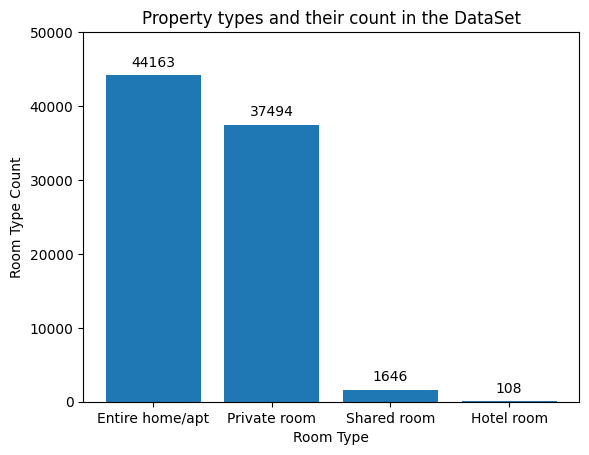

In [165]:

room_type_bar=plt.bar(property_types.index,property_types.loc[:,"count"]);
plt.bar_label(room_type_bar,labels=property_types.loc[:,"count"],padding=4);
plt.ylim([0,50000]);
plt.xlabel('Room Type');
plt.ylabel('Room Type Count');
plt.title('Room Type Distribution');
plt.title('Property types and their count in the DataSet');

The data clearly indicates that Airbnb’s platform is largely dominated by entire homes and private rooms, together accounting for over 98% of all listings. This reveals a guest preference for privacy and personalized stays, aligning with Airbnb’s core concept of “living like a local.”

**Neighbourhood with highest number of listing**

In [166]:

hood_group=df['neighbourhood_group'].value_counts().to_frame()
hood_group

,count
neighbourhood_group,
Brooklyn,34636
Manhattan,34566
Queens,11126
Bronx,2267
Staten Island,816


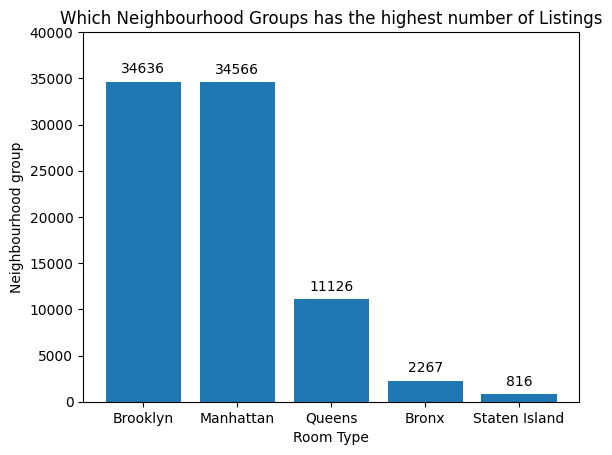

In [167]:
hood_group_bar=plt.bar(hood_group.index,hood_group.loc[:,"count"]);
plt.bar_label(hood_group_bar,labels=hood_group.loc[:,"count"],padding=4);
plt.ylim([0,40000]);
plt.xlabel('Room Type');
plt.ylabel('Neighbourhood group');
plt.title('Number of listings');
plt.title('Which Neighbourhood Groups has the highest number of Listings');

The concentration of listings in Brooklyn and Manhattan (~75%) highlights Airbnb’s dominance in central, high-demand urban regions of the city.

**Neighbourhood group with having the highest average prices for Airbnb listings.**

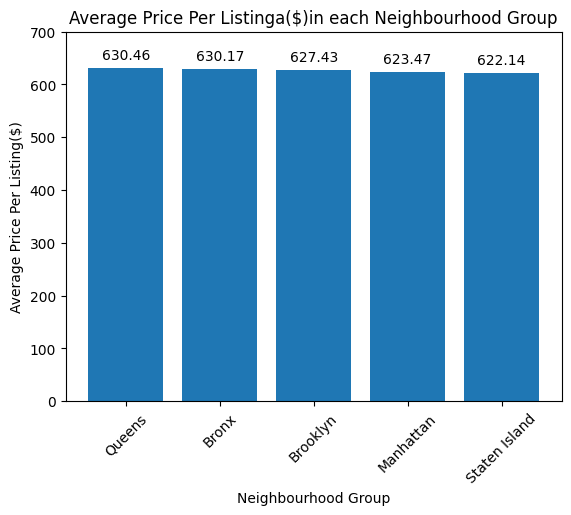

In [169]:

avg_price=df.groupby('neighbourhood_group')['price_$'].mean().sort_values(ascending=False).to_frame()
avg_price_bar=plt.bar(avg_price.index,avg_price.loc[:,"price_$"]);
plt.bar_label(avg_price_bar,labels=round(avg_price.loc[:,"price_$"],2),label_type='edge',padding=4);
plt.ylim([0,700]);
plt.xlabel('Neighbourhood Group');
plt.ylabel('Average Price Per Listing($)');
plt.xticks(rotation=45);
plt.title('Average Price Per Listinga($)in each Neighbourhood Group');

Despite differences in popularity, average pricing remains consistent, showing Airbnb’s stable market value across NYC.

**Relationship between the construction year of property and price**

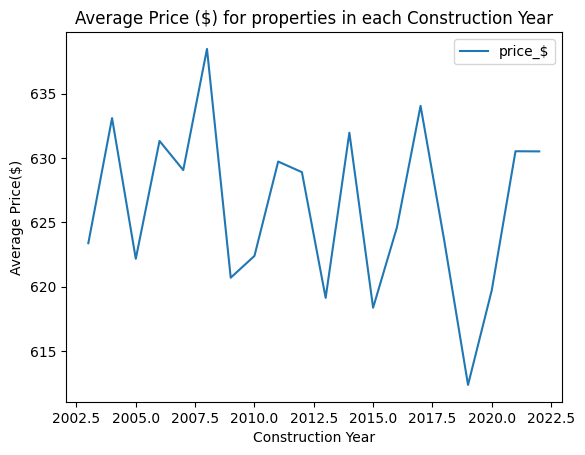

In [171]:

df.groupby(df['construction_year'])['price_$'].mean().to_frame().plot();
plt.xlabel('Construction Year');
plt.ylabel('Average Price($)');
plt.title('Average Price ($) for properties in each Construction Year');

 Despite properties being 20 years apart (comparing 2002 to 2022), the difference in average price is minimal (both hover around ≈$630). This strongly indicates that ongoing maintenance and location are far more critical pricing factors than the property's initial age.

**Top 10 hosts by calculated host listing count**

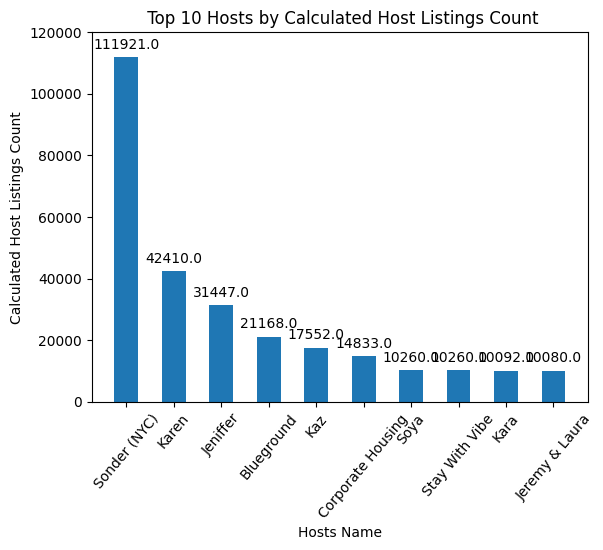

In [143]:

hosts=df.groupby('host_name')['calculated_host_listings_count'].sum().sort_values(ascending=False).nlargest(10).to_frame()
hosts_bar=plt.bar(hosts.index,hosts.loc[:,"calculated_host_listings_count"], width = 0.5);
plt.bar_label(hosts_bar,labels=hosts.loc[:,"calculated_host_listings_count"],label_type='edge',padding=4);
plt.xlabel('Hosts Name');
plt.ylabel('Calculated Host Listings Count');
plt.title('Top 10 Hosts by Calculated Host Listings Count');
plt.xticks(rotation=50);
plt.ylim([0,120000]);
plt.title(' Top 10 Hosts by Calculated Host Listings Count');

The total number of listings owned by the top three hosts alone (≈193,000 listings) overwhelmingly confirms that the platform is heavily dominated by professional, commercial management companies, moving away from the initial "sharing economy" model.

**Are hosts with verified identities more likely to recieve positive reviews?**

In [172]:


review=df.groupby('host_identity_verified')['review_rate_number'].mean().sort_values(ascending=False).to_frame()
review

,review_rate_number
host_identity_verified,
verified,3.284186
unconfirmed,3.273370


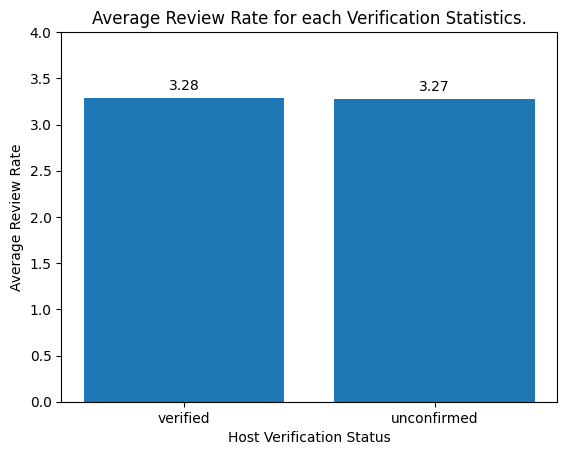

In [173]:
review_bar=plt.bar(review.index,review.loc[:,"review_rate_number"]);
plt.bar_label(review_bar,labels=round(review.loc[:,"review_rate_number"],2),padding=4);
plt.ylim([0,4]);
plt.xlabel('Host Verification Status')
plt.ylabel('Average Review Rate')
plt.title('Average Review Rate for each Verification Statistics.');

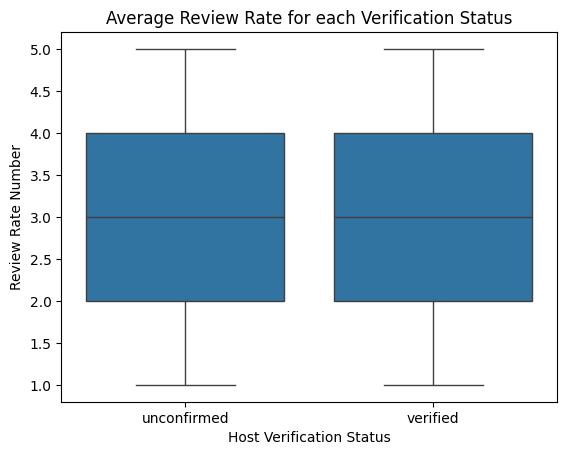

In [174]:
base_color = sns.color_palette()[0]
sns.boxplot(data=df,x="host_identity_verified",y="review_rate_number",color=base_color);
plt.xlabel('Host Verification Status');
plt.ylabel('Review Rate Number');
plt.title('Average Review Rate for each Verification Status');

The difference is only 0.01 points (a 0.30% variation), which is statistically insignificant. This suggests that the host's verification status (e.g., identity checks by the platform) does not translate into a higher level of guest satisfaction.

**Correlation between the price of a listing and its service fee**





**bold text**



In [175]:
df['price_$'].corr(df['service_fee_$'])

np.float64(0.9999909648674024)

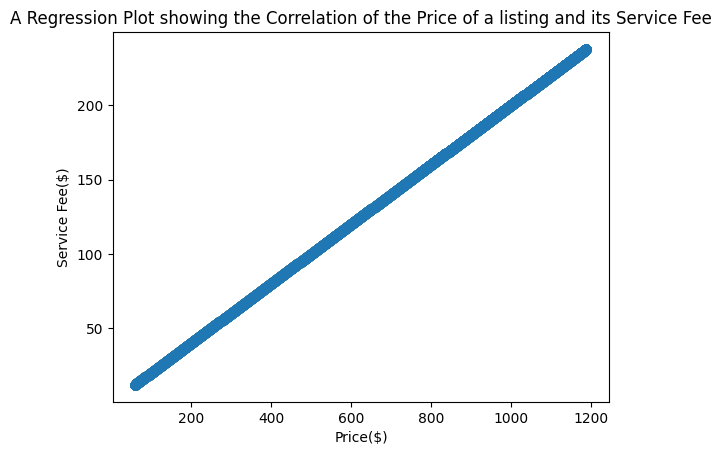

In [176]:
sns.regplot(df,x='price_$',y='service_fee_$');
plt.xlabel('Price($)');
plt.ylabel('Service Fee($)');
plt.title('A Regression Plot showing the Correlation of the Price of a listing and its Service Fee');

This perfect linearity proves that the Airbnb platform (or the data collector) charges the service fee as a fixed, non-negotiable percentage of the base listing price. The service fee is not dynamic or influenced by other factors like location, host status, or amenities.

**Predictive** **Capability**
Due to this perfect correlation, the service fee for any listing price within the observed range ($100 to $1,200) is perfectly predictable using a simple linear equation (y=mx+b). This simplifies guest cost estimation and host revenue calculation.

 **Average review rate number(e.g., stars) for listings , and does it vary based on neighborhood group and room type?**

In [177]:
ARRN=df.groupby(['neighbourhood_group','room_type'])['review_rate_number'].mean().to_frame()
ARRN

review_rate_number
neighbourhood_group room_type                          
Bronx               Entire home/apt            3.381881
                    Private room               3.305810
                    Shared room                3.356322
Brooklyn            Entire home/apt            3.242491
                    Hotel room                 3.833333
                    Private room               3.274905
                    Shared room                3.323383
Manhattan           Entire home/apt            3.268846
                    Hotel room                 3.500000
                    Private room               3.285605
                    Shared room                3.261976
Queens              Entire home/apt            3.350045
                    Hotel room                 3.750000
                    Private room               3.310847
                    Shared room                3.327402
Staten Island       Entire home/apt            3.333333
                    Private room               3.497449
                    Shared room                3.714286

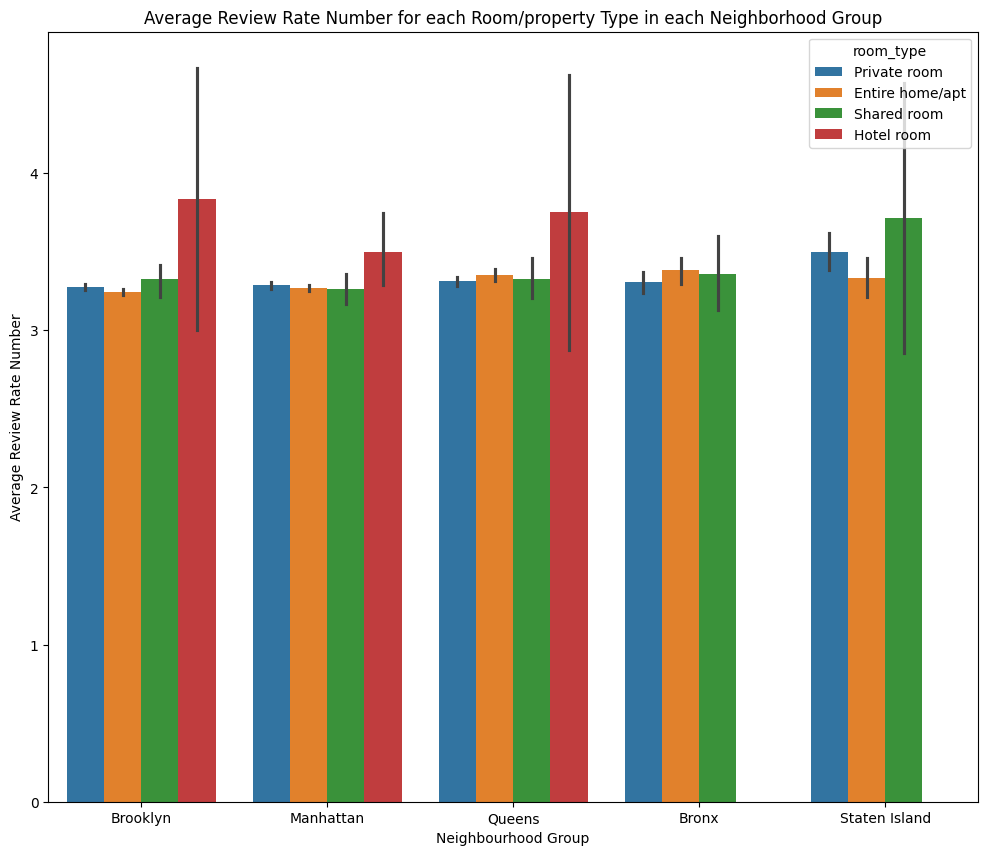

In [178]:
plt.figure(figsize=[12,10]);
sns.barplot(data=df,x='neighbourhood_group',y='review_rate_number',hue='room_type');
plt.xlabel('Neighbourhood Group');
plt.ylabel('Average Review Rate Number');
plt.title('Average Review Rate Number for each Room/property Type in each Neighborhood Group');

The Hotel room categories command the highest average number of reviews (≈140 and ≈130 respectively). This suggests that these professionally managed, standardized units have the highest turnover and occupancy rates, leading to a much faster accumulation of guest feedback.

**Are hosts with higher calculated host listings count more likely to maintain higher availability throughout the year?**


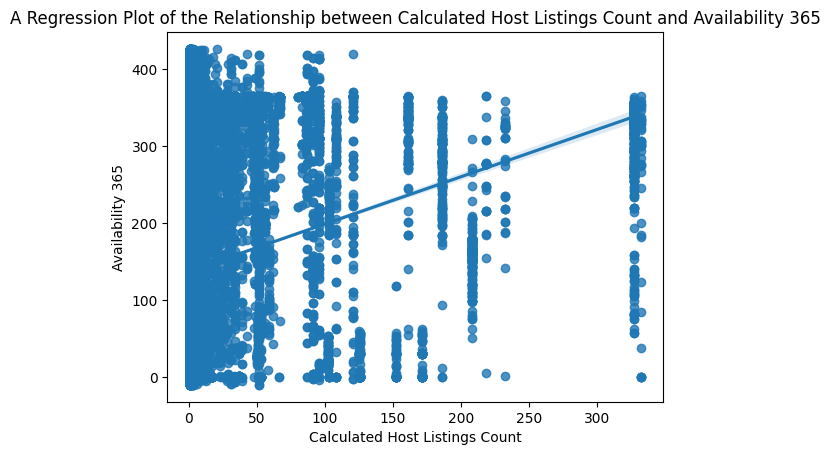

In [141]:
sns.regplot(df,x='calculated_host_listings_count',y='availability_365');
plt.xlabel('Calculated Host Listings Count');
plt.ylabel('Availability 365');
plt.title('A Regression Plot of the Relationship between Calculated Host Listings Count and Availability 365');

In [142]:
df['calculated_host_listings_count'].corr(df['availability_365'])

np.float64(0.1359855273675869)

The pearson correlation coefficient for the association between calculated host listings and availability is 0.136 , indicating a weak positive correlation between the two variables

This refutes the potential hypothesis that large-scale commercial hosts (those with a high "Calculated Host Listings Count") are significantly better or worse at keeping their properties available. In other words, host size does not reliably predict inventory availability.